# **Step 3**

### Install Riskfolio

In [1]:
!pip install riskfolio-lib --quiet

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import riskfolio as rp
from matplotlib.ticker import FuncFormatter
import seaborn as sns

warnings.filterwarnings("ignore")

### Select a historical time period: Jan 1 2018 to Dec 31 2022 and get the data for the stocks. In addition, only select the adj close and calculate the percent change daily

In [3]:
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2018-01-01'
end = '2023-01-01'

# Tickers of assets
my_stocks = sorted(['MCHP', 'CIEN', 'WDC', 'INTC', 'KLAC', 'SANM', 'MU',
                'ADBE', 'MA', 'CRM', 'IPGP', 'LRCX', 'HPQ', 'VNT', 'PYPL'])
bond_etf = ['BND','BNDX','VCIT']
leveraged_etf = ['SOXL','TQQQ']
my_etfs = sorted(bond_etf + leveraged_etf)
all_assets = my_stocks + my_etfs

# Downloading data for stock portfolio
data = yf.download(my_stocks, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = my_stocks
#Calculating returns
stock_returns = data[my_stocks].pct_change().dropna()
display(stock_returns.head())

[*********************100%%**********************]  15 of 15 completed


,ADBE,CIEN,CRM,HPQ,INTC,IPGP,KLAC,LRCX,MA,MCHP,MU,PYPL,SANM,VNT,WDC
Date,,,,,,,,,,,,,,,
2020-09-25,2.5894%,1.2880%,2.1848%,0.8265%,1.5867%,0.9299%,1.8262%,0.9475%,1.0877%,1.3299%,-0.6671%,2.7773%,-1.7524%,0.0000%,2.5047%
2020-09-28,1.8196%,1.1699%,1.6190%,3.0601%,2.9836%,1.3577%,2.8418%,1.9196%,1.9923%,4.0585%,1.1803%,2.5474%,5.1958%,-2.9412%,0.3899%
2020-09-29,0.1679%,0.5279%,0.3162%,0.3182%,-0.4667%,0.6219%,0.0414%,0.7158%,-0.6383%,-0.3202%,1.9911%,1.2915%,0.1106%,-7.5758%,1.8125%
2020-09-30,0.2248%,-0.7502%,1.5640%,0.3699%,1.1526%,1.0163%,0.2121%,-1.7648%,0.5770%,0.0195%,-7.3950%,1.3008%,-0.4050%,1.6393%,-7.0448%
2020-10-01,1.8514%,0.1260%,0.8475%,0.0527%,0.8884%,1.7827%,2.7047%,2.2246%,1.5377%,4.1748%,2.0443%,-0.0457%,-0.4066%,9.6774%,-0.6019%


### Set an equal weight for all 15 stocks, calculate the daily return and assign it to a variable called MY_STOCK_Portf

In [4]:
# Calculate the Historical Return series of an equal-weighted portfolio of stocks
stock_port_weights = [1/15]*len(my_stocks)
weighted_returns = (stock_port_weights * stock_returns)
stock_port_ret = weighted_returns.sum(axis=1) # Historical Returns of the Stock Portion
stock_port_ret = pd.DataFrame(stock_port_ret)
stock_port_ret.columns = ['MY_STOCK_Portf']
display(stock_port_ret.head())

,MY_STOCK_Portf
Date,
2020-09-25,1.1639%
2020-09-28,1.9463%
2020-09-29,-0.0724%
2020-09-30,-0.6189%
2020-10-01,1.7905%


### Get the adjusted close percent change data for the bond etfs

In [5]:
# Collect the returns data for the ETFs
# Downloading data for stock portfolio
data = yf.download(my_etfs, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = my_etfs
#Calculating returns
etf_returns = data[my_etfs].pct_change().dropna()
etf_returns = pd.DataFrame(etf_returns)
display(etf_returns.head())

[*********************100%%**********************]  5 of 5 completed


,BND,BNDX,SOXL,TQQQ,VCIT
Date,,,,,
2018-01-03,0.0861%,0.0738%,4.9776%,2.9279%,0.0803%
2018-01-04,-0.0491%,0.0184%,1.7550%,0.5863%,-0.0229%
2018-01-05,-0.1352%,0.0000%,1.8062%,3.0200%,-0.0688%
2018-01-08,0.0123%,0.0184%,2.2485%,1.1122%,-0.0345%
2018-01-09,-0.2954%,-0.0552%,-2.8739%,0.0763%,-0.2754%


### Merging the stock portfolio return and etf return to one dataframe

In [6]:
# Now, combine the historical returns of the ETFs with the Stock Portfolio Returns
all_returns = pd.merge(etf_returns,stock_port_ret,on='Date')
display(all_returns.head())

,BND,BNDX,SOXL,TQQQ,VCIT,MY_STOCK_Portf
Date,,,,,,
2020-09-25,-0.0114%,0.1549%,4.3152%,7.0080%,-0.0419%,1.1639%
2020-09-28,0.0907%,0.0344%,8.1655%,5.9285%,0.3558%,1.9463%
2020-09-29,0.0680%,0.0687%,0.8335%,-1.0484%,-0.0313%,-0.0724%
2020-09-30,-0.1584%,-0.1202%,0.1345%,1.9788%,-0.0730%,-0.6189%
2020-10-01,0.1022%,0.0447%,6.2088%,4.6830%,0.2562%,1.7905%


### Calculate the initial weight of each etf and stock portfolio before adding the constraints

In [7]:
# Building the portfolio object
port = rp.Portfolio(returns=all_returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BND,BNDX,SOXL,TQQQ,VCIT,MY_STOCK_Portf
weights,0.0000%,0.0000%,100.0000%,0.0000%,0.0000%,0.0000%


### Creating a weights variable to store only the ones that have weighting over 0% for the pie chart

In [8]:
weights = w["weights"].to_list()
weights = [ round(elem, 2) for elem in weights ]
weights = pd.DataFrame(weights, columns=['weights'])
weights = weights.set_index(w.index)
weights = weights[weights["weights"] != 0]

### Viewing the portfolio composition based on the sharpe mean variance in a pie chart

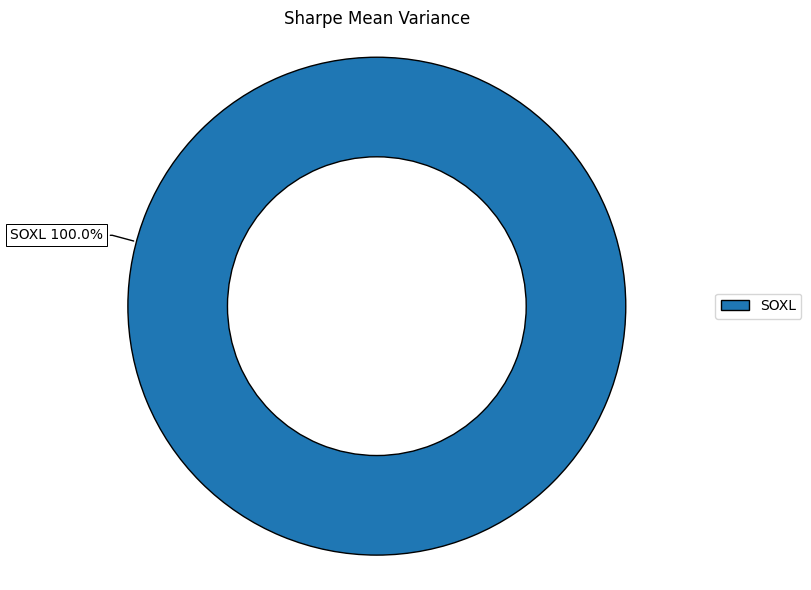

In [9]:
# Plotting the composition of the portfolio

fig = plt.figure(figsize=(4, 6))

ax = rp.plot_pie(w=weights, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", ax=None)

ax.set_facecolor('whitesmoke')
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.show()

### Plotting the Efficient Frontier Mean Plot

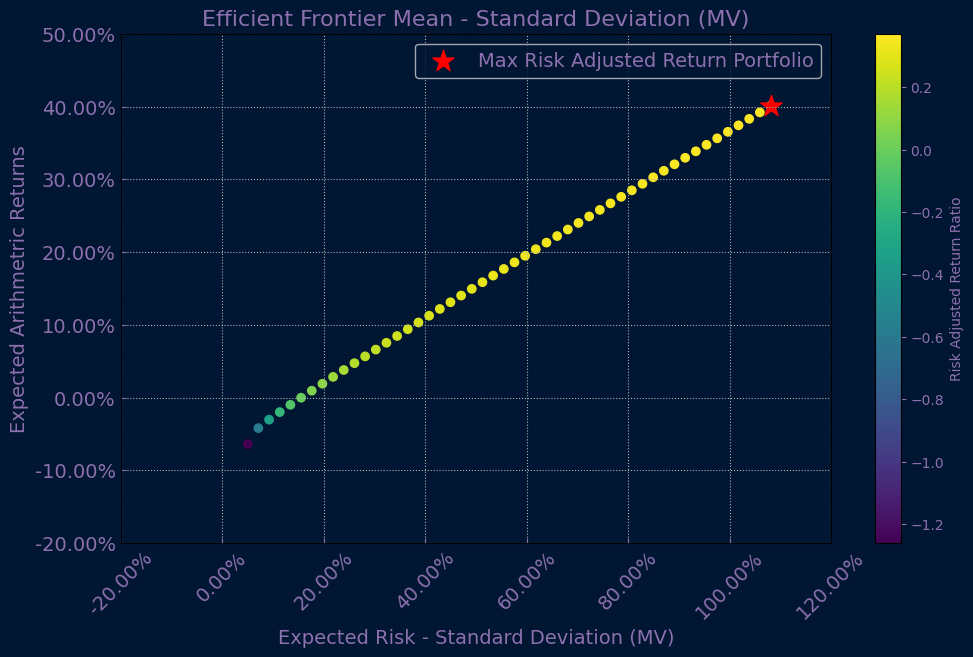

In [11]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf,
                                   hist=hist)

# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig = plt.figure(figsize=(12, 6), facecolor="#001633")

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns,
                      rm=rm, rf=rf, alpha=0.05, cmap='viridis', w=w,
                      label=label, marker='*', s=16, c='r', height=6, width=10,
                      ax=None)

ax.set_xlabel('Expected Risk - Standard Deviation (MV)', fontsize=14)
ax.set_ylabel('Expected Arithmetric Returns', fontsize=14)
ax.set_title('Efficient Frontier Mean - Standard Deviation (MV)', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', facecolor='#001633', fontsize=14)
ax.set_facecolor('#001633')
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
plt.show()

### Adding the constraints and specifying the bond class needs to be more than 10% and the stock weighting needs to be more than 50%

In [12]:

asset_classes = {'Assets': ['BND', 'BNDX', 'SOXL', 'TQQQ', 'VCIT',
                            'MY_STOCK_Portf'],
                 'Group': ['BOND-ETF', 'BOND-ETF', 'LEVERAGED-ETF',
                           'LEVERAGED-ETF', 'BOND-ETF', 'MY_STOCKS']}

asset_classes = pd.DataFrame(asset_classes)
#asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False],
               'Type': ['Classes', 'Classes'],
               'Set': ['Group', 'Group'],
               'Position': ['BOND-ETF', 'MY_STOCKS'],
               'Sign': ['>=', '>='],
               'Weight': [0.1, 0.5],
               'Type Relative': ['', ''],
               'Relative Set': ['', ''],
               'Relative': ['', ''],
               'Factor': ['', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Group,BOND-ETF,>=,10.0000%,,,,
1,False,Classes,Group,MY_STOCKS,>=,50.0000%,,,,


### Viewing the asset classes

In [13]:
display(asset_classes)

,Assets,Group
0,BND,BOND-ETF
1,BNDX,BOND-ETF
2,SOXL,LEVERAGED-ETF
3,TQQQ,LEVERAGED-ETF
4,VCIT,BOND-ETF
5,MY_STOCK_Portf,MY_STOCKS


### Adding the constraints to the constraints to the asset classes

In [14]:
A, B = rp.assets_constraints(constraints, asset_classes)

### Calculating the weighting for each group such that it meets the constraints

In [15]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BND,BNDX,SOXL,TQQQ,VCIT,MY_STOCK_Portf
weights,0.0000%,10.0000%,40.0000%,0.0000%,0.0000%,50.0000%


In [16]:
my_weights = w.T
my_weights.columns = ['BND', 'BNDX', 'SOXL', 'TQQQ', 'VCIT', 'MY_STOCKS']
display(my_weights)

,BND,BNDX,SOXL,TQQQ,VCIT,MY_STOCKS
weights,0.0000%,10.0000%,40.0000%,0.0000%,0.0000%,50.0000%


### Creating a optimized weights variable to store the weights that have more than 0 for the pie chart plotting

In [17]:
optimized_weights = w["weights"].to_list()
optimized_weights = [ round(elem, 2) for elem in optimized_weights ]
optimized_weights = pd.DataFrame(optimized_weights, columns=['weights'])
optimized_weights = optimized_weights.set_index(w.index)
optimized_weights = optimized_weights[optimized_weights["weights"] != 0]

### Plotting the portfolio composition in a pie chart

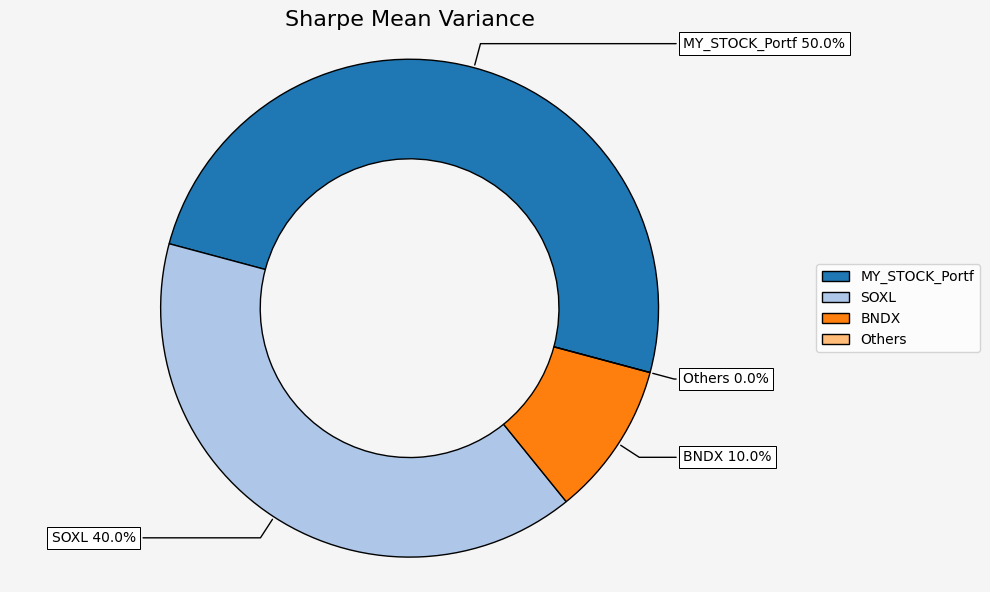

In [19]:
fig = plt.figure(figsize=(9, 6), facecolor="whitesmoke")

rp.plot_pie(w=optimized_weights, title='Sharpe Mean Variance', others=0.01, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

plt.title('Sharpe Mean Variance', fontsize=16)
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.show()

### Plotting the Efficient Frontier Mean Plot after the constraints have been added

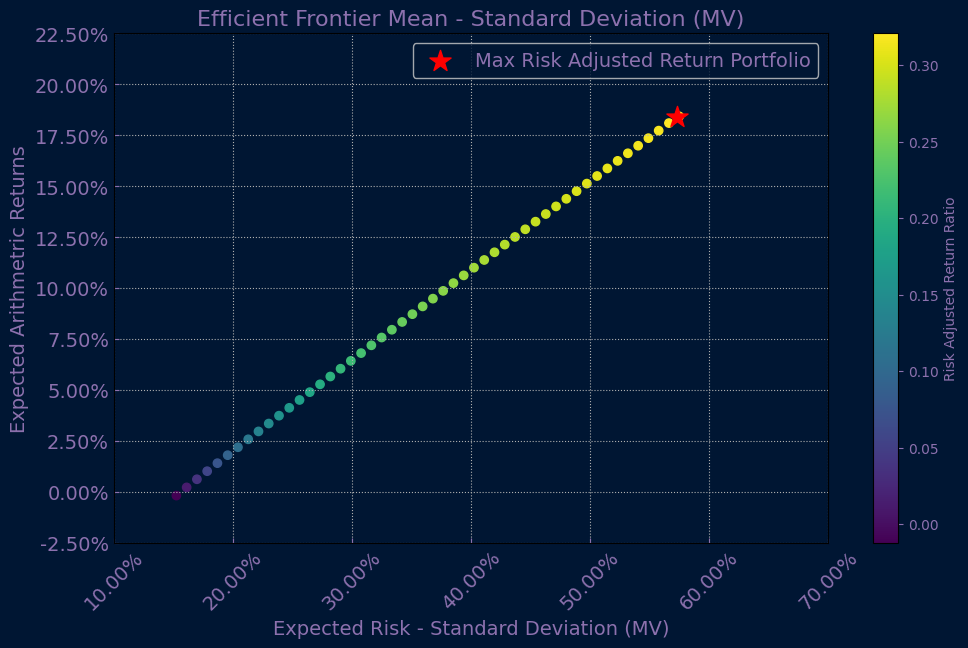

In [21]:
points = 50 # Number of points of the frontier

frontier_optimized = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf,
                                   hist=hist)

# Plotting the efficient frontier

# Title of point
label = 'Max Risk Adjusted Return Portfolio'
# Expected returns
mu_optimized = port.mu
# Covariance matrix
cov_optimized = port.cov
# Returns of the assets
returns_optimized = port.returns

fig = plt.figure(figsize=(12, 6), facecolor="#001633")

ax = rp.plot_frontier(w_frontier=frontier_optimized, mu=mu_optimized,
                      cov=cov_optimized, returns=returns_optimized,
                      rm=rm, rf=rf, alpha=0.05, cmap='viridis', w=w,
                      label=label, marker='*', s=16, c='r', height=6, width=10,
                      ax=None)

ax.set_xlabel('Expected Risk - Standard Deviation (MV)', fontsize=14)
ax.set_ylabel('Expected Arithmetric Returns', fontsize=14)
ax.set_title('Efficient Frontier Mean - Standard Deviation (MV)', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', facecolor='#001633', fontsize=14)
ax.set_facecolor('#001633')
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
plt.show()

### Getting the 2023 data for all the stocks and etfs

In [22]:
# Date range
start = "2023-01-01"
end = "2023-11-01"

# Downloading data for stock portfolio
data = yf.download(sorted(my_stocks), start = start, end = end)
data_stocks = data["Adj Close"].pct_change().add(1).dropna()
data_stocks.columns = my_stocks
#Calculating returns
stocks_returns = data_stocks
stocks_returns

[*********************100%%**********************]  15 of 15 completed


,ADBE,CIEN,CRM,HPQ,INTC,IPGP,KLAC,LRCX,MA,MCHP,MU,PYPL,SANM,VNT,WDC
Date,,,,,,,,,,,,,,,
2023-01-04,101.3327%,97.3985%,103.5688%,101.7570%,103.5541%,104.0004%,100.9773%,101.9696%,102.4077%,102.4457%,107.6037%,104.1700%,98.9255%,103.7697%,105.2213%
2023-01-05,96.2010%,99.9798%,97.6718%,99.9633%,99.5665%,99.6413%,98.2221%,98.7218%,99.0483%,97.6127%,100.9410%,98.1722%,98.5043%,97.9872%,106.5961%
2023-01-06,101.3123%,104.0680%,103.0585%,104.2264%,104.2453%,103.9304%,106.4584%,106.7640%,104.6896%,105.3111%,103.7653%,100.2753%,102.4403%,104.5591%,105.5067%
2023-01-09,102.7739%,100.9918%,104.6901%,100.9873%,102.0188%,99.9423%,102.7013%,101.6080%,100.8976%,101.4154%,99.2778%,100.7845%,104.0056%,102.0125%,101.1299%
2023-01-10,99.0409%,99.9037%,100.2311%,101.5712%,100.4435%,101.6079%,101.9445%,101.3660%,100.0108%,102.2358%,101.5082%,101.0898%,99.7625%,101.3152%,101.5430%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,96.5861%,98.2916%,96.4940%,99.5031%,94.9118%,97.2210%,96.7210%,96.5763%,99.8449%,93.8840%,97.6936%,94.9299%,97.7135%,97.7441%,98.1844%
2023-10-26,98.6837%,99.3880%,99.5890%,100.5378%,99.0557%,98.2805%,100.7475%,100.3068%,94.3776%,101.9333%,97.0376%,100.5049%,101.8600%,100.7578%,90.7065%
2023-10-27,98.8022%,101.0345%,100.1631%,98.7390%,109.2866%,100.1477%,99.9324%,99.8103%,99.8601%,99.3128%,101.7356%,97.3720%,99.6269%,99.6239%,101.8557%


In [23]:
# Downloading data for stock portfolio
data = yf.download(sorted(my_etfs), start = start, end = end)
data_etf = data["Adj Close"].pct_change().add(1).dropna()
data_etf.columns = my_etfs
#Calculating returns
etf_returns = data_etf
display(etf_returns.head())

[*********************100%%**********************]  5 of 5 completed


,BND,BNDX,SOXL,TQQQ,VCIT
Date,,,,,
2023-01-04,100.5677%,100.4180%,107.5855%,101.5376%,100.6549%
2023-01-05,99.8899%,99.8751%,95.0348%,95.2825%,99.7832%
2023-01-06,101.1027%,100.6460%,113.5841%,107.8239%,101.2657%
2023-01-09,100.2727%,99.7516%,106.0718%,102.0975%,100.3787%
2023-01-10,99.6057%,99.8547%,103.8161%,102.6652%,99.7988%


### Merging the datasets

In [24]:
asset_returns = pd.merge(etf_returns,stocks_returns,on='Date')
asset_returns

,BND,BNDX,SOXL,TQQQ,VCIT,ADBE,CIEN,CRM,HPQ,INTC,IPGP,KLAC,LRCX,MA,MCHP,MU,PYPL,SANM,VNT,WDC
Date,,,,,,,,,,,,,,,,,,,,
2023-01-04,100.5677%,100.4180%,107.5855%,101.5376%,100.6549%,101.3327%,97.3985%,103.5688%,101.7570%,103.5541%,104.0004%,100.9773%,101.9696%,102.4077%,102.4457%,107.6037%,104.1700%,98.9255%,103.7697%,105.2213%
2023-01-05,99.8899%,99.8751%,95.0348%,95.2825%,99.7832%,96.2010%,99.9798%,97.6718%,99.9633%,99.5665%,99.6413%,98.2221%,98.7218%,99.0483%,97.6127%,100.9410%,98.1722%,98.5043%,97.9872%,106.5961%
2023-01-06,101.1027%,100.6460%,113.5841%,107.8239%,101.2657%,101.3123%,104.0680%,103.0585%,104.2264%,104.2453%,103.9304%,106.4584%,106.7640%,104.6896%,105.3111%,103.7653%,100.2753%,102.4403%,104.5591%,105.5067%
2023-01-09,100.2727%,99.7516%,106.0718%,102.0975%,100.3787%,102.7739%,100.9918%,104.6901%,100.9873%,102.0188%,99.9423%,102.7013%,101.6080%,100.8976%,101.4154%,99.2778%,100.7845%,104.0056%,102.0125%,101.1299%
2023-01-10,99.6057%,99.8547%,103.8161%,102.6652%,99.7988%,99.0409%,99.9037%,100.2311%,101.5712%,100.4435%,101.6079%,101.9445%,101.3660%,100.0108%,102.2358%,101.5082%,101.0898%,99.7625%,101.3152%,101.5430%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,99.2440%,99.4132%,87.8521%,92.6753%,99.3312%,96.5861%,98.2916%,96.4940%,99.5031%,94.9118%,97.2210%,96.7210%,96.5763%,99.8449%,93.8840%,97.6936%,94.9299%,97.7135%,97.7441%,98.1844%
2023-10-26,100.6739%,100.4848%,98.3968%,94.1715%,100.6194%,98.6837%,99.3880%,99.5890%,100.5378%,99.0557%,98.2805%,100.7475%,100.3068%,94.3776%,101.9333%,97.0376%,100.5049%,101.8600%,100.7578%,90.7065%
2023-10-27,100.0000%,100.1678%,102.5119%,101.4258%,99.9197%,98.8022%,101.0345%,100.1631%,98.7390%,109.2866%,100.1477%,99.9324%,99.8103%,99.8601%,99.3128%,101.7356%,97.3720%,99.6269%,99.6239%,101.8557%


### Calculate the cummulative product of each stock and etf, add the weight class and take a sum to calculate the daily portfolio return

In [25]:
asset_returns_cumprod = asset_returns.cumprod()

port_weights =[my_weights.BND] + [my_weights.BNDX] + [my_weights.SOXL] + [my_weights.TQQQ] + [my_weights.VCIT] + [(1/15)*my_weights.MY_STOCKS]*len(my_stocks)
port_weights= np.transpose(port_weights)

weighted_asset_returns = port_weights * asset_returns_cumprod


display(weighted_asset_returns.shape)
port_ret_2023 = weighted_asset_returns.sum(axis=1)
C_port_ret = pd.DataFrame(port_ret_2023)
C_port_ret.columns = ['Portfolio']
display(C_port_ret)

(208, 20)

,Portfolio
Date,
2023-01-04,104.3794%
2023-01-05,101.8575%
2023-01-06,109.5421%
2023-01-09,113.2135%
2023-01-10,115.5765%
...,...
2023-10-25,132.7515%
2023-10-26,131.0497%
2023-10-27,132.9943%


### Calculating the portfolio returns on October 31 2023

In [26]:
overall_return = ((C_port_ret[(len(C_port_ret)-1):] - 1).iloc[0]["Portfolio"])*100
print(f"Portfolio Return: {overall_return:.2f}%")

Portfolio Return: 33.21%


### Print the 5% VaR of the portfolio with actual data

In [27]:
var = np.percentile(C_port_ret,5)
var

1.2029756909890021

### Plot the portfolio returns for 2023

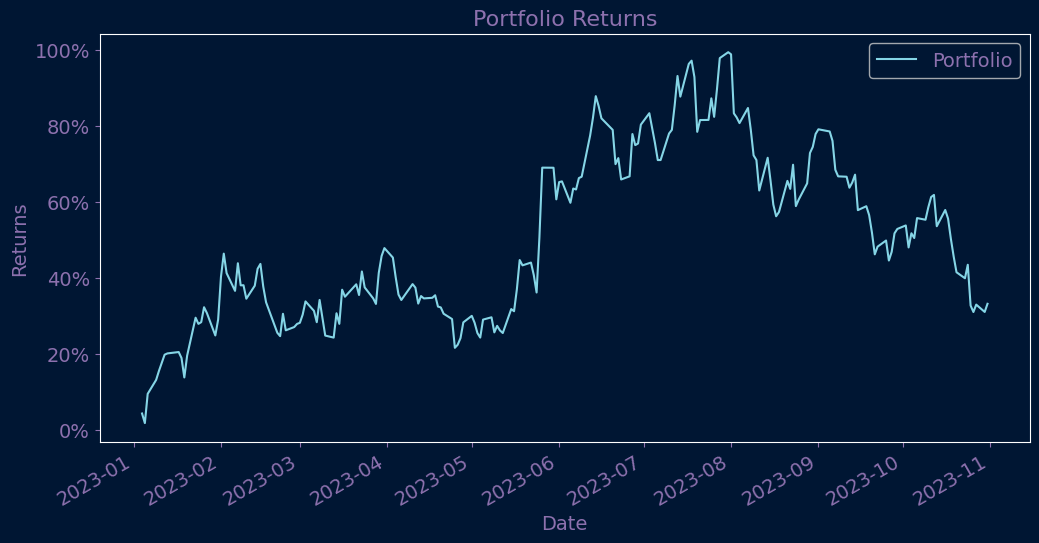

In [28]:
# Create a new figure and set the figure size
fig = plt.figure(figsize=(12, 6), facecolor="#001633")

# Add a subplot to the figure
ax1 = fig.add_subplot(1, 1, 1)

# Plot the cumulative return data
C_port_ret.plot(ax=ax1, label='Portfolio', color='#85d5e6')

# Set the x- and y-axis labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Returns', fontsize=14)
ax1.set_title('Portfolio Returns', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))
ax1.set_facecolor('#001633')
#plt.rcParams['axes.facecolor'] = '#001633'
# Add a legend
for axis in ['top', 'bottom', 'left', 'right']:
  ax1.spines[axis].set_color('white')

plt.legend(loc='best', facecolor='#001633', fontsize=14)
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
# Show the plot
plt.show()

### Get the S&P 500 Data for Jan 1 2023 to October 31 2023

In [29]:
warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Download data for S&P 500 index
symbol = "^GSPC"
sp500 = yf.download(symbol, start=start, end=end)

# Extract adjusted close prices
sp500_daily_return = sp500['Adj Close'].pct_change().dropna()

sp500_daily_return.head()

[*********************100%%**********************]  1 of 1 completed


Date
2023-01-04    0.7539%
2023-01-05   -1.1646%
2023-01-06    2.2841%
2023-01-09   -0.0768%
2023-01-10    0.6978%
Name: Adj Close, dtype: float64

### Calculate the total return of the S&P 500 from Jan 1 2023 to October 31 2023

In [30]:
# Cumulative Portfolio Return
sp500_ret = (1 + sp500_daily_return).cumprod()

print("Last Portfolio Value:")
display(sp500_ret[(len(sp500_ret)-1):])

Last Portfolio Value:


Date
2023-10-31   109.6665%
Name: Adj Close, dtype: float64

### Compare our portfolio vs the S&P 500 in 2023

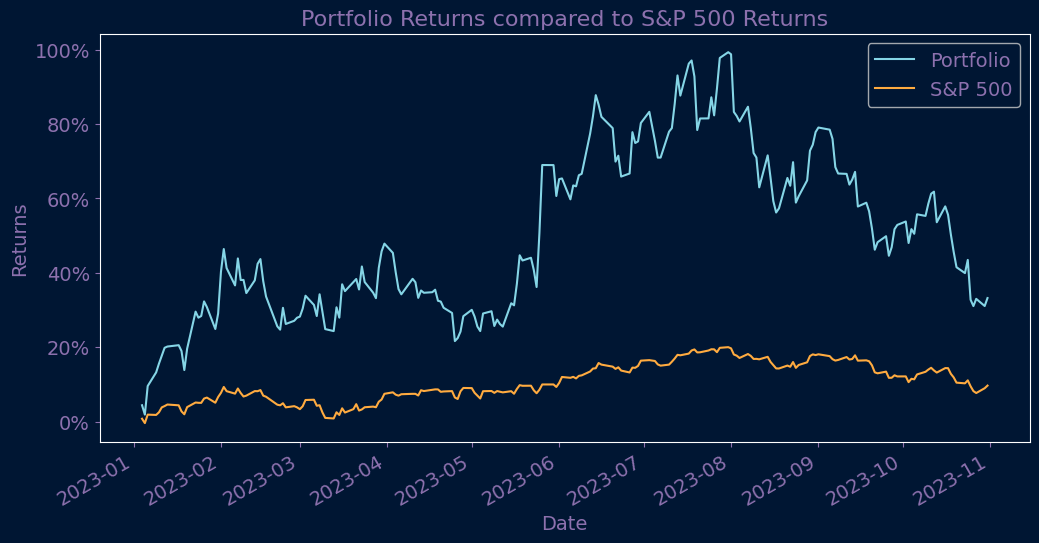

In [31]:
# Create a new figure and set the figure size
fig = plt.figure(figsize=(12, 6), facecolor="#001633")

# Add a subplot to the figure
ax1 = fig.add_subplot(1, 1, 1)

# Plot the cumulative return data
C_port_ret.plot(ax=ax1, label='Portfolio', color='#85d5e6')

# Plot S&P 60 returns
sp500_ret.plot(ax=ax1, label='S&P 500', color='#ffab40')

# Set the x- and y-axis labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Returns', fontsize=14)
ax1.set_title('Portfolio Returns compared to S&P 500 Returns', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))
ax1.set_facecolor('#001633')
#plt.rcParams['axes.facecolor'] = '#001633'
# Add a legend
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_color('white')

plt.legend(loc='best', facecolor='#001633', fontsize=14)
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
# Show the plot
plt.show()

### Download the data from TSX 60 from Jan 1 2023 to October 31 2023

In [32]:
warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Download data for TSX 60 index
symbol = "XIU.TO"
tsx60 = yf.download(symbol, start=start, end=end)

# Extract adjusted close prices
tsx60_daily_return = tsx60['Adj Close'].pct_change().dropna()

tsx60_daily_return.head()

[*********************100%%**********************]  1 of 1 completed


Date
2023-01-04    0.6727%
2023-01-05   -0.3341%
2023-01-06    1.6091%
2023-01-09    0.1650%
2023-01-10    0.0659%
Name: Adj Close, dtype: float64

### Calculate the total return of the TSX 60 stocks from Jan 1 2023 to October 31 2023

In [33]:
# Cumulative Portfolio Return
tsx60_ret = (1 + tsx60_daily_return).cumprod()

print("Last Portfolio Value:")
display(tsx60_ret[(len(tsx60_ret)-1):])

Last Portfolio Value:


Date
2023-10-31   99.1802%
Name: Adj Close, dtype: float64

### Compare our portfolio with the TSX 60 for 2023

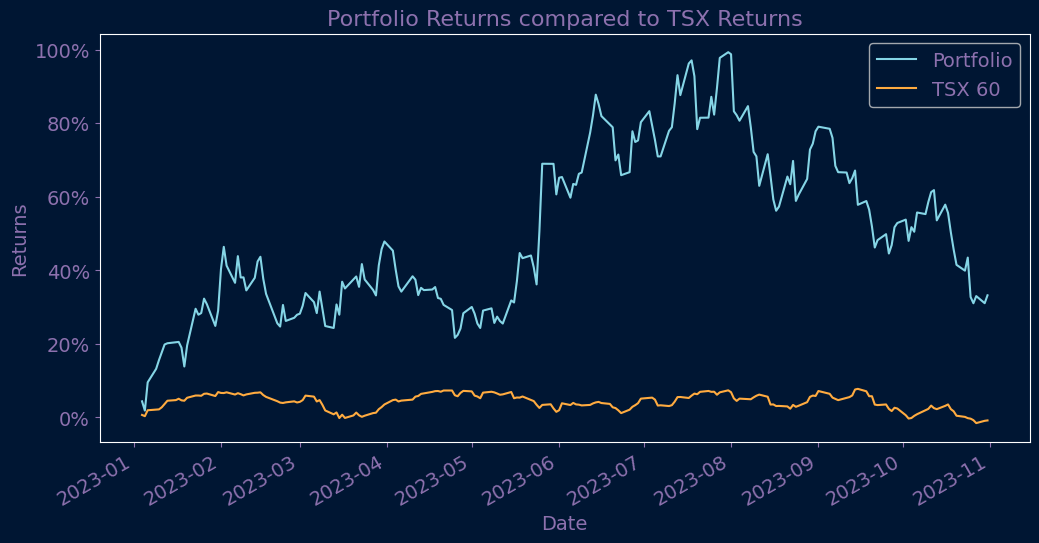

In [34]:
# Create a new figure and set the figure size
fig = plt.figure(figsize=(12, 6), facecolor="#001633")

# Add a subplot to the figure
ax1 = fig.add_subplot(1, 1, 1)

# Plot the cumulative return data
C_port_ret.plot(ax=ax1, label='Portfolio', color='#85d5e6')

# Plot TSX 60 returns
tsx60_ret.plot(ax=ax1, label='TSX 60', color='#ffab40')

# Set the x- and y-axis labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Returns', fontsize=14)
ax1.set_title('Portfolio Returns compared to TSX Returns', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))
ax1.set_facecolor('#001633')
#plt.rcParams['axes.facecolor'] = '#001633'
# Add a legend
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_color('white')

plt.legend(loc='best', facecolor='#001633', fontsize=14)
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
# Show the plot
plt.show()

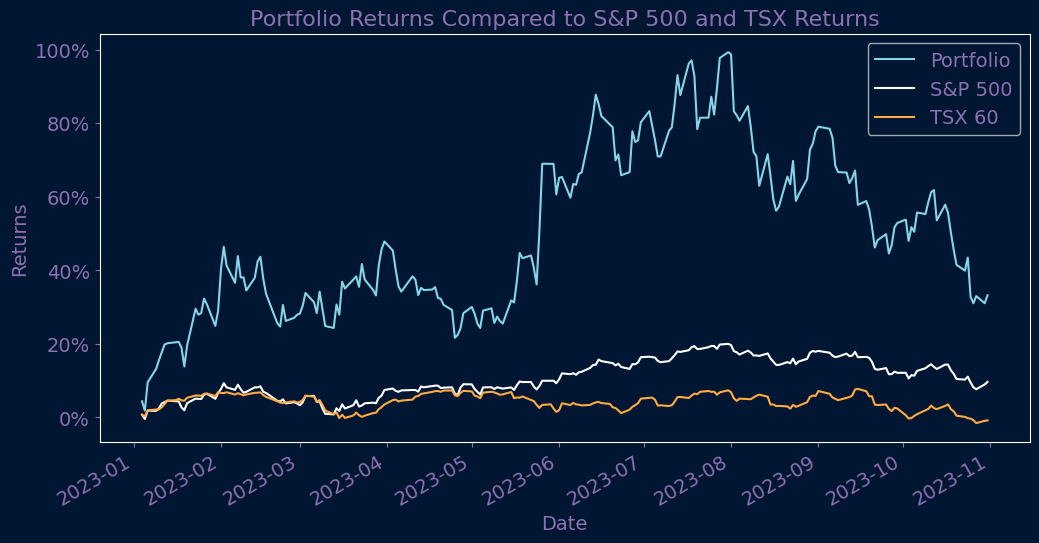

In [35]:
# Create a new figure and set the figure size
fig = plt.figure(figsize=(12, 6), facecolor="#001633")

# Add a subplot to the figure
ax1 = fig.add_subplot(1, 1, 1)

# Plot the cumulative return data
C_port_ret.plot(ax=ax1, label='Portfolio', color='#85d5e6')

sp500_ret.plot(ax=ax1, label='S&P 500', color='#ffffff')

# Plot TSX 60 returns
tsx60_ret.plot(ax=ax1, label='TSX 60', color='#ffab40')

# Set the x- and y-axis labels and title
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Returns', fontsize=14)
ax1.set_title('Portfolio Returns Compared to S&P 500 and TSX Returns', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))
ax1.set_facecolor('#001633')
#plt.rcParams['axes.facecolor'] = '#001633'
# Add a legend
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_color('white')

plt.legend(loc='best', facecolor='#001633', fontsize=14)
plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'
# Show the plot
plt.show()

### Calculate the covariance matrix, mean and standard deviation of our portfolio

In [36]:
returns = all_returns

my_portfolio_value = 10000000
T = 10/12
N_SIMS = 10 ** 5

cov_mat = returns.cov()
mu = np.mean(returns, axis=0).values*252
sigma = np.std(returns, axis=0).values*np.sqrt(252)

display(sigma)
display(mu)

array([0.05897268, 0.05073724, 1.07989066, 0.76460556, 0.069161  ,
       0.29194566])

array([-0.06508942, -0.06374161,  0.40092956,  0.07465209, -0.06043811,
        0.06003374])

### The simulation code for the Geometric Brownian Motion

In [37]:

def GBMsimulator(seed, So, mu, sigma, Cov, T, N):
    """
    Parameters
    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    np.random.seed(seed)
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

### Run 10000 simulations of the geometric brownian motion to calculate the portfolio returns

In [38]:
seed = 22

dim = len(w); T = 10/12; N_SIMS = 10000

S0 = np.array([1, 1, 1, 1, 1, 1])
N_steps = int(T*252)

assets, time = GBMsimulator(seed, S0, mu, sigma, cov_mat, T, N_steps)


# Number of Simulations

np.random.seed(seed)


Simulated_Paths = np.zeros([N_SIMS, dim, N_steps])

Simulated_Paths[0, :, :] = assets

for k in range(1, N_SIMS):
    seed = int(np.random.uniform(1,2**32-1,1))
    Simulated_Paths[k, :, :] = GBMsimulator(seed, S0, mu, sigma, cov_mat, T,
                                            N_steps)[0]



display(Simulated_Paths.shape)

(10000, 6, 210)

### Print the portfolio percentage for Jan 1 2023 to October 31 2023

In [39]:
Simul_Last_Values = Simulated_Paths[:,:,(N_steps-1)]
#display(Simul_Last_Values.shape)
Simul_Last_Portf_Values = w.transpose().values*Simul_Last_Values
#display(Simul_Last_Portf_Values.shape)
X = pd.DataFrame(Simul_Last_Portf_Values).sum(axis=1)
display(X)

0      98.1455%
1      95.9904%
2      92.5597%
3      94.7423%
4      91.5169%
         ...   
9995   97.4416%
9996   95.9553%
9997   89.9932%
9998   94.0090%
9999   94.6206%
Length: 10000, dtype: float64

### Plotted the returns as a probability density function

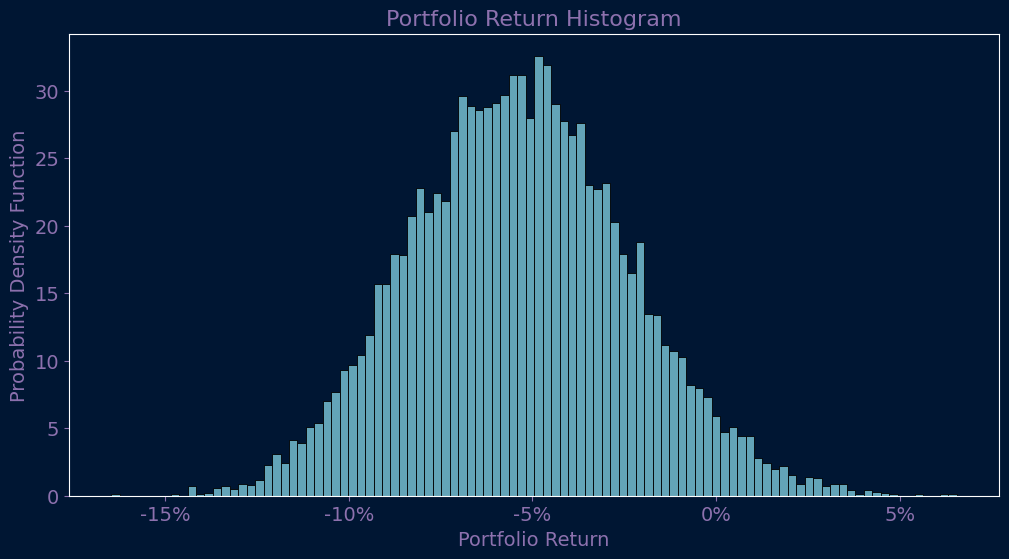

In [40]:
fig = plt.figure(figsize=(12, 6), facecolor="#001633")
ax = fig.add_subplot(1, 1, 1)
sns.histplot(X, bins=100, stat='probability', color="#85d5e6")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _:f'{x * 1000:.0f}'))
plt.xlabel('Portfolio Return', fontsize=14)
plt.ylabel('Probability Density Function', fontsize=14)
plt.title('Portfolio Return Histogram', fontsize=16)
plt.xticks([0.85, 0.90, 0.95, 1, 1.05], ["-15%", "-10%", "-5%", "0%", "5%"], fontsize=14)
plt.yticks(fontsize=14)
ax.set_facecolor('#001633')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('white')

plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'


plt.show()


### Calculate the portfolio and profit and loss of the return at the end of October 31 2023

In [41]:
pd.options.display.float_format = '{:.4f}'.format
X_df = X.to_frame(name='Returns')
X_df["Portfolio Value"] = X_df["Returns"] * my_portfolio_value
X_df["P/L"] = X_df["Portfolio Value"] - my_portfolio_value
X_df

,Returns,Portfolio Value,P/L
0,0.9815,9814552.5851,-185447.4149
1,0.9599,9599038.3989,-400961.6011
2,0.9256,9255972.2536,-744027.7464
3,0.9474,9474234.2191,-525765.7809
4,0.9152,9151690.2161,-848309.7839
...,...,...,...
9995,0.9744,9744158.9612,-255841.0388
9996,0.9596,9595526.8862,-404473.1138
9997,0.8999,8999324.2573,-1000675.7427
9998,0.9401,9400900.1989,-599099.8011


### Calculate the 5% VaR of the simulated portfolio

In [42]:
# Sorting the portfolio differences in ascending order
# This helps us determine the worst losses (located at the beginning of the
#sorted array)
P_diff_sorted = np.sort(X_df["P/L"])

# Specifying the percentile levels at which we want to calculate
#Value-at-Risk (VaR)
# VaR is a measure of the risk of large losses
# Here, we choose percentiles that correspond to very low probabilities,
# indicating that we're interested in rare but severe losses
percentiles = [5]

# Using the numpy.percentile() function to calculate the VaR at the specified
#percentiles
# The function takes the sorted differences in portfolio values and the
#desired percentiles as inputs
var = np.percentile(P_diff_sorted, percentiles)

# Looping over the calculated VaR values and their corresponding percentiles
for x, y in zip(percentiles, var):
    # Printing the VaR for each percentile
    # The print statement is structured to answer the question:
    # "With y% confidence, what is the maximum amount we expect to lose in
    #one day?"
    print(f'1-day VaR with {100-x}% confidence: ${(y):.2f}')


1-day VaR with 95% confidence: $-1016859.81


### Plotted the probability density function using the profit and loss of the portfolio

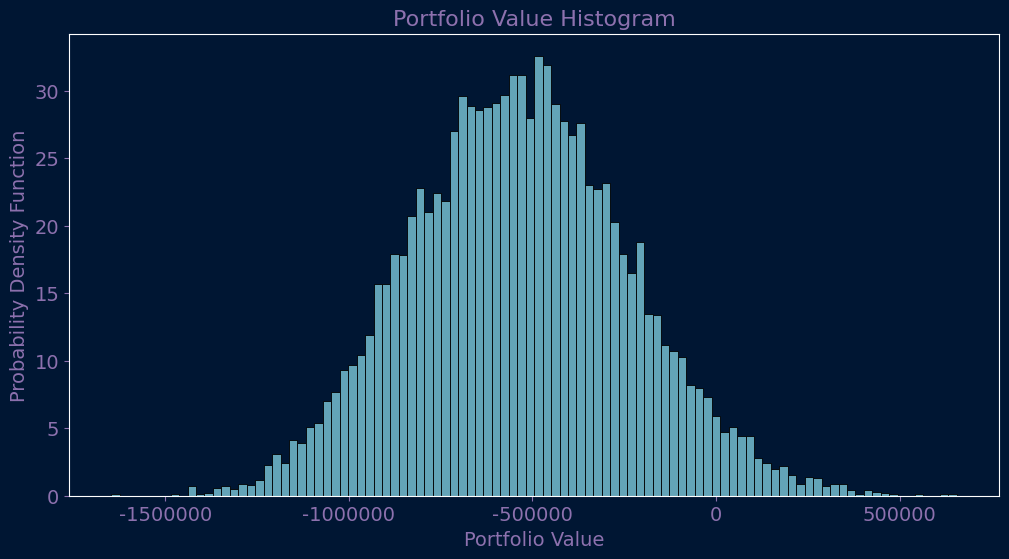

In [43]:
fig = plt.figure(figsize=(12, 6), facecolor="#001633")
ax = fig.add_subplot(1, 1, 1)
sns.histplot(X_df["P/L"], bins=100, stat='probability', color="#85d5e6")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _:f'{x * 1000:.0f}'))
plt.xlabel('Portfolio Value', fontsize=14)
plt.ylabel('Probability Density Function', fontsize=14)
plt.title('Portfolio Value Histogram', fontsize=16)
plt.xticks([-1500000, -1000000, -500000, 0, 500000], ["-1500000", "-1000000", "-500000", "0", "500000"], fontsize=14)
plt.yticks(fontsize=14)

ax.set_facecolor('#001633')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('white')

plt.rcParams['text.color'] = '#8D71AE'
plt.rcParams['axes.labelcolor'] = '#8D71AE'
plt.rcParams['xtick.color'] = '#8D71AE'
plt.rcParams['ytick.color'] = '#8D71AE'


plt.show()


### Load the adjusted close price for the stocks and etf

In [44]:
# Downloading data for stock portfolio
data = yf.download(sorted(my_stocks), start = start, end = end)
adj_close_stock = data['Adj Close'].dropna()
adj_close_stock.head()

[*********************100%%**********************]  15 of 15 completed


,ADBE,CIEN,CRM,HPQ,INTC,IPGP,KLAC,LRCX,MA,MCHP,MU,PYPL,SANM,VNT,WDC
Date,,,,,,,,,,,,,,,
2023-01-03,336.9200,50.7400,134.7800,26.0410,26.1203,96.4900,372.0359,410.4264,344.6968,68.1176,50.0904,74.5800,56.7700,19.5790,31.4100
2023-01-04,341.4100,49.4200,139.5900,26.4985,27.0487,100.3500,375.6718,418.5102,352.9962,69.7836,53.8992,77.6900,56.1600,20.3171,33.0500
2023-01-05,328.4400,49.4100,136.3400,26.4888,26.9314,99.9900,368.9928,413.1606,349.6367,68.1176,54.4063,76.2700,55.3200,19.9081,35.2300
2023-01-06,332.7500,51.4200,140.5100,27.6083,28.0747,103.9200,392.8237,441.1069,366.0334,71.7355,56.4549,76.4800,56.6700,20.8158,37.1700
2023-01-09,341.9800,51.9300,147.1000,27.8809,28.6415,103.8600,403.4349,448.2000,369.3187,72.7508,56.0472,77.0800,58.9400,21.2347,37.5900


In [45]:
# Downloading data for etf portfolio
data = yf.download(sorted(my_etfs), start = start, end = end)
adj_close_etfs = data['Adj Close'].dropna()
adj_close_etfs.head()

[*********************100%%**********************]  5 of 5 completed


,BND,BNDX,SOXL,TQQQ,VCIT
Date,,,,,
2023-01-03,70.3812,47.1258,9.3161,16.7002,75.4457
2023-01-04,70.7808,47.3228,10.0227,16.9569,75.9398
2023-01-05,70.7028,47.2637,9.5251,16.1570,75.7751
2023-01-06,71.4824,47.5690,10.8190,17.4211,76.7342
2023-01-09,71.6774,47.4508,11.4759,17.7865,77.0248


### Merge the dataset

In [46]:
adj_close = pd.merge(adj_close_etfs,adj_close_stock,on='Date')
adj_close

,BND,BNDX,SOXL,TQQQ,VCIT,ADBE,CIEN,CRM,HPQ,INTC,IPGP,KLAC,LRCX,MA,MCHP,MU,PYPL,SANM,VNT,WDC
Date,,,,,,,,,,,,,,,,,,,,
2023-01-03,70.3812,47.1258,9.3161,16.7002,75.4457,336.9200,50.7400,134.7800,26.0410,26.1203,96.4900,372.0359,410.4264,344.6968,68.1176,50.0904,74.5800,56.7700,19.5790,31.4100
2023-01-04,70.7808,47.3228,10.0227,16.9569,75.9398,341.4100,49.4200,139.5900,26.4985,27.0487,100.3500,375.6718,418.5102,352.9962,69.7836,53.8992,77.6900,56.1600,20.3171,33.0500
2023-01-05,70.7028,47.2637,9.5251,16.1570,75.7751,328.4400,49.4100,136.3400,26.4888,26.9314,99.9900,368.9928,413.1606,349.6367,68.1176,54.4063,76.2700,55.3200,19.9081,35.2300
2023-01-06,71.4824,47.5690,10.8190,17.4211,76.7342,332.7500,51.4200,140.5100,27.6083,28.0747,103.9200,392.8237,441.1069,366.0334,71.7355,56.4549,76.4800,56.6700,20.8158,37.1700
2023-01-09,71.6774,47.4508,11.4759,17.7865,77.0248,341.9800,51.9300,147.1000,27.8809,28.6415,103.8600,403.4349,448.2000,369.3187,72.7508,56.0472,77.0800,58.9400,21.2347,37.5900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,68.0578,47.3564,14.9700,32.7700,73.9857,521.1400,40.8500,197.0600,26.0300,32.7224,89.5600,453.5915,583.3400,386.3100,71.3800,66.5000,51.4900,50.0000,29.0300,42.1800
2023-10-26,68.5164,47.5860,14.7300,30.8600,74.4440,514.2800,40.6000,196.2500,26.1700,32.4134,88.0200,456.9821,585.1300,364.5900,72.7600,64.5300,51.7500,50.9300,29.2500,38.2600
2023-10-27,68.5164,47.6659,15.1000,31.3000,74.3842,508.1200,41.0200,196.5700,25.8400,35.4235,88.1500,456.6730,584.0200,364.0800,72.2600,65.6500,50.3900,50.7400,29.1400,38.9700


In [47]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: #01796F' if is_max.any() else 'background-color: #800000' for v in is_max]

### Create a mock portfolio using the allocation calculated above

In [48]:
pd.options.display.float_format = '{:.2f}'.format
port_weights =[my_weights.BND] + [my_weights.BNDX] + [my_weights.SOXL] + [my_weights.TQQQ] + [my_weights.VCIT] + [(1/15)*my_weights.MY_STOCKS]*len(my_stocks)

portfolio = pd.DataFrame(port_weights).reset_index().drop(columns=['index']).rename(columns={0: 'Weights'})
portfolio["Weights (%)"] = (portfolio["weights"]*100).apply(lambda x: float("{:.2f}".format(x)))
portfolio = portfolio.drop(columns=["weights"])
portfolio['Ticker'] = my_etfs + my_stocks
portfolio['Amount Allocated ($)'] = np.floor(portfolio['Weights (%)']* my_portfolio_value)

purhcase_price = adj_close.iloc[:1].transpose().reset_index()
purhcase_price.columns = ['Ticker', 'Purchase Price ($)']

sell_price = adj_close.iloc[-1:].transpose().reset_index()
sell_price.columns = ['Ticker', 'Final Price ($)']

portfolio = pd.merge(pd.merge(purhcase_price,sell_price, on='Ticker'),portfolio,on='Ticker')

portfolio['Number of Shares'] = portfolio['Amount Allocated ($)']/portfolio['Purchase Price ($)']

portfolio['Book Cost ($)'] = portfolio['Number of Shares'] * portfolio['Purchase Price ($)']

portfolio['Investments ($)'] = portfolio['Number of Shares'] * portfolio['Final Price ($)']

portfolio['Profit/Loss ($)'] = (portfolio['Investments ($)'] - portfolio['Book Cost ($)'])

portfolio['Profit/Loss (%)'] = ((portfolio['Investments ($)'] - portfolio['Book Cost ($)'])/(portfolio['Book Cost ($)']))*100

portfolio = portfolio.dropna()

portfolio.style.apply(highlight_greaterthan, threshold=0.0, column=['Profit/Loss ($)'], axis=1).set_properties(**{'color': 'white', 'font-size': '110%'}).hide_index()


Ticker,Purchase Price ($),Final Price ($),Weights (%),Amount Allocated ($),Number of Shares,Book Cost ($),Investments ($),Profit/Loss ($),Profit/Loss (%)
BNDX,47.125843,47.596001,10.000000,100000000.000000,2121977.953751,100000000.000000,100997664.111412,997664.111412,0.997664
SOXL,9.316053,14.900000,40.000000,400000000.000000,42936636.710109,400000000.000000,639755870.601591,239755870.601591,59.938968
ADBE,336.920013,532.059998,3.330000,33300000.000000,98836.515116,33300000.000000,52586955.991266,19286955.991266,57.918787
CIEN,50.740002,42.200001,3.330000,33300000.000000,656286.931384,33300000.000000,27695309.005129,-5604690.994871,-16.830904
CRM,134.779999,200.830002,3.330000,33300000.000000,247069.300353,33300000.000000,49618928.042322,16318928.042322,49.005790
HPQ,26.040991,26.330000,3.330000,33300000.000000,1278753.186393,33300000.000000,33669571.300154,369571.300154,1.109824
INTC,26.120346,36.380375,3.330000,33300000.000000,1274868.254487,33300000.000000,46380185.057100,13080185.057100,39.279835
IPGP,96.489998,85.900002,3.330000,33300000.000000,345113.490903,33300000.000000,29645249.395179,-3654750.604821,-10.975227
KLAC,372.035889,468.410736,3.330000,33300000.000000,89507.493804,33300000.000000,41926271.057558,8626271.057558,25.904718
LRCX,410.426422,588.219971,3.330000,33300000.000000,81135.127286,33300000.000000,47725302.194916,14425302.194916,43.319226


### Portfolio Summary by Asset Classes

In [49]:
portfolio_returns = portfolio[['Ticker', 'Weights (%)', 'Book Cost ($)',
                               'Investments ($)', 'Profit/Loss ($)']]
portfolio_stocks = pd.DataFrame(portfolio_returns.iloc[:, 1:].iloc[2:,:].sum(axis=0))
portfolio_stocks = portfolio_stocks.rename(columns={0: 'My Stocks'})
portfolio_stocks = portfolio_stocks.transpose()
portfolio_stocks = portfolio_stocks.reset_index()
portfolio_stocks = portfolio_stocks.rename(columns={'index': 'Ticker'})
portfolio_etf = portfolio_returns.iloc[0:2]
portfolio_returns = pd.concat([portfolio_etf, portfolio_stocks], axis=0)
portfolio_returns['Profit/Loss (%)'] = ((portfolio_returns['Profit/Loss ($)'])/(portfolio_returns['Book Cost ($)']))*100
portfolio_returns["Ticker"] = ['Bond ETFs', 'Leveraged ETFs', 'My Stocks']
portfolio_returns = portfolio_returns.rename(columns={'Ticker': 'Asset Classes'})
portfolio_returns.style.apply(highlight_greaterthan, threshold=0.0, column=['Profit/Loss ($)'], axis=1).set_properties(**{'color': 'white', 'font-size': '110%'}).hide_index()

Asset Classes,Weights (%),Book Cost ($),Investments ($),Profit/Loss ($),Profit/Loss (%)
Bond ETFs,10.000000,100000000.000000,100997664.111412,997664.111412,0.997664
Leveraged ETFs,40.000000,400000000.000000,639755870.601591,239755870.601591,59.938968
My Stocks,49.950000,499500000.000000,590721107.832760,91221107.832760,18.262484


### Calculate the Portfolio Return to ensure it matches the return calculated above

In [50]:
portfolio_return = ((portfolio['Profit/Loss ($)'].sum())/portfolio['Book Cost ($)'].sum())*100
print(f"Portfolio Return: {portfolio_return:.2f}%")

Portfolio Return: 33.21%
